In [1]:
import cutlass
import torch
import numpy as np

dtype = torch.float32
plan = cutlass.Gemm(element=dtype, layout=cutlass.LayoutType.ColumnMajor)
plan.activation = cutlass.epilogue.gelu

In [2]:
import torch.nn as nn
class SimpleFullyConnected(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.act = nn.GELU()

    def forward(self, x):
        return self.act(self.fc(x))

In [3]:
class MyFullyConnected(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
        

    def forward(self, x):
        output = torch.zeros(x.shape[0], self.out_features, device=x.device)
        plan.run(x, self.weight, output, output)
        return output

In [4]:
tensor_sizes = [1536, 2304, 3072, 3840, 4608, 5376, 6144]
import time
my_times = []
pytorch_times = []
for size in tensor_sizes:
    input_tensor = torch.randn(size, size).cuda()
    pytorch_model = SimpleFullyConnected(size,8*size).cuda()
    my_model = MyFullyConnected(size,8*size).cuda()
    
    start = time.perf_counter()
    for i in range(200):
        output = my_model(input_tensor)
    end = time.perf_counter()
    my_times.append((end-start)/200.0)

    start = time.perf_counter()
    for i in range(200):
        output = pytorch_model(input_tensor)
    end = time.perf_counter()
    pytorch_times.append((end-start)/200.0)

In [5]:
my_times

[0.002539164444897324,
 0.0025439943256787955,
 0.002764044364448637,
 0.004012031028978526,
 0.006089097859803588,
 0.00862961339065805,
 0.01257660294417292]

In [9]:
pytorch_times[0] = 3.080750968307254e-05

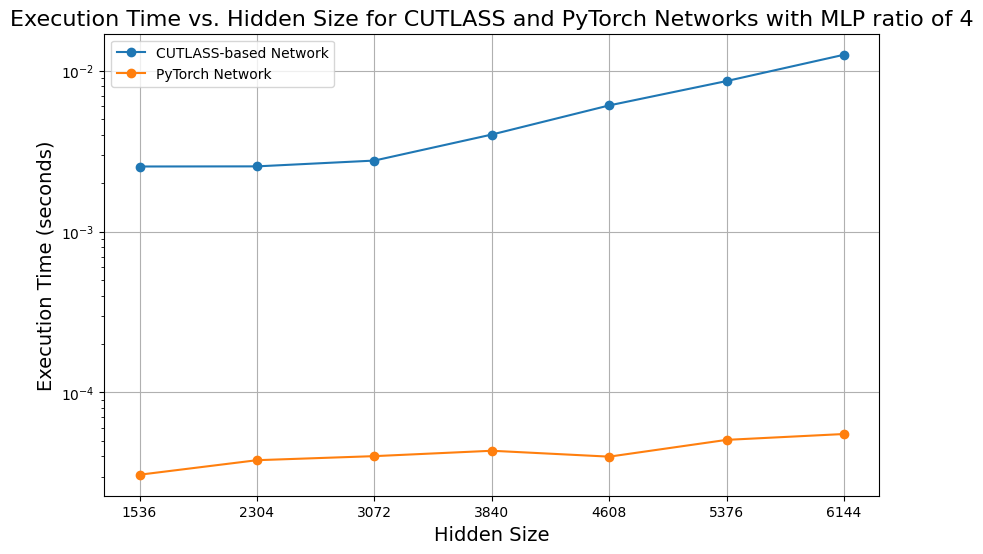

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(tensor_sizes, my_times, label='CUTLASS-based Network', marker='o')
plt.plot(tensor_sizes, pytorch_times, label='PyTorch Network', marker='o')

plt.xlabel('Hidden Size', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)
plt.title('Execution Time vs. Hidden Size for CUTLASS and PyTorch Networks with MLP ratio of 4', fontsize=16)
plt.grid(True)
plt.legend()
plt.xticks(tensor_sizes)
plt.yscale('log')  # To handle the large difference in execution time
plt.savefig('plot.png')

In [1]:
import torch
import torch.nn as nn
import cutlass

class MyMultiHeadSelfAttention((nn.Module)):
    def __init__(self, embed_dim, num_heads, dtype=torch.float32):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Initialize linear projections
        self.query_proj = torch.nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_proj = torch.nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_proj = torch.nn.Linear(embed_dim, embed_dim, bias=False)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim, bias=False)
        self.just_gemm = cutlass.Gemm(element=torch.float32, layout=cutlass.LayoutType.ColumnMajor)


    def _cutlass_gemm(self, A, B):
        """Perform matrix multiplication using CUTLASS GEMM."""
        C = torch.zeros(A.size(0), B.size(1), device=A.device, dtype=torch.float32)
        D = torch.zeros(A.size(0), B.size(1), device=A.device, dtype=torch.float32)
        
        self.just_gemm.run(A, B, C, D)
        return D

    def _scaled_dot_product_attention(self, Q, K, V):
        """Compute scaled dot-product attention using CUTLASS."""
        scale = (self.head_dim) ** -0.5
        K = K.transpose(-1, -2).squeeze()
        Q = Q.squeeze()
        V = V.squeeze()
        attn_scores = self._cutlass_gemm(Q, K) * scale
        attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)
        return self._cutlass_gemm(attn_probs, V)

    def forward(self, x):
        batch_size, seq_length, embed_dim = x.shape
        
        Q = self.query_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention output
        attn_output = self._scaled_dot_product_attention(Q, K, V)
        attn_output = attn_output.unsqueeze(0).unsqueeze(0)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, embed_dim)

        return self.out_proj(attn_output)

In [7]:
embedding_sizes = [768, 1536, 2304, 3072, 3840, 4608, 5376, 6144]
pytorch_times = []
my_times = []

In [8]:
import time
for emb_size in embedding_sizes:
    input_tensor = torch.randn(1, 256, emb_size).cuda()
    multihead_attn = nn.MultiheadAttention(emb_size, 1).cuda()
    start = time.perf_counter()
    for i in range(200):
        attn, _ = multihead_attn(input_tensor, input_tensor, input_tensor)
    end = time.perf_counter()
    pytorch_times.append((end-start)/200)
    
    my_multihead_attn = MyMultiHeadSelfAttention(emb_size, 1).cuda()
    start = time.perf_counter()
    for i in range(200):
        my_attn = my_multihead_attn(input_tensor)
    end = time.perf_counter()
    my_times.append((end-start)/200)
    


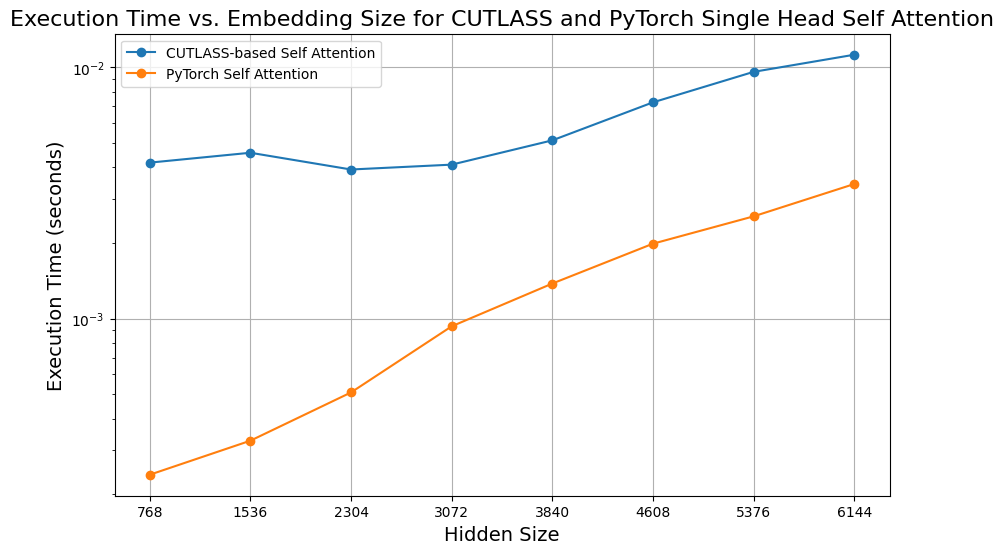

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(embedding_sizes, my_times, label='CUTLASS-based Self Attention', marker='o')
plt.plot(embedding_sizes, pytorch_times, label='PyTorch Self Attention', marker='o')

plt.xlabel('Hidden Size', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)
plt.title('Execution Time vs. Embedding Size for CUTLASS and PyTorch Single Head Self Attention', fontsize=16)
plt.grid(True)
plt.legend()
plt.xticks(embedding_sizes)
plt.yscale('log')  # To handle the large difference in execution time
plt.savefig('plot.png')